<a href="https://colab.research.google.com/github/victor-onoja/DeepLearningLearning/blob/main/RNN_Timeseries_data_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2025-03-19 12:48:33--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.177.136, 52.216.184.125, 16.15.193.209, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.177.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  42.4MB/s    in 0.3s    

2025-03-19 12:48:34 (42.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [ ]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os
frame = os.path.join("jena_climate_2009_2016.csv")

with open(frame) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


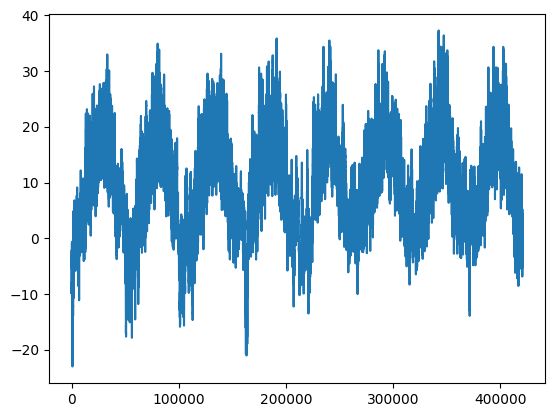

In [ ]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

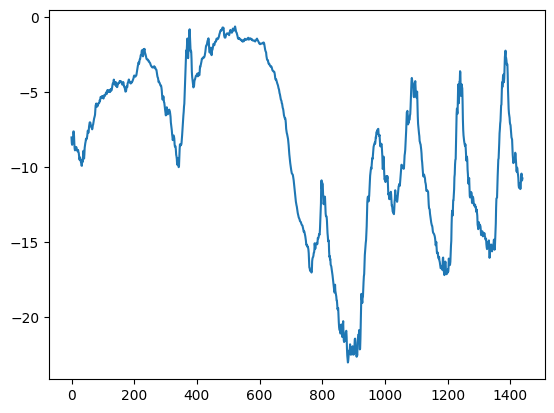

In [ ]:
plt.plot(range(1440), temperature[:1440])

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 10.28
Test MAE: 10.40


samples shape: (256, 120, 14)
targets shape: (256,)
Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 114s 138ms/step - loss: 104.4822 - mae: 8.2849 - val_loss: 66.3165 - val_mae: 6.6977
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 131ms/step - loss: 76.5311 - mae: 7.0837 - val_loss: 65.3659 - val_mae: 6.6546
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 107s 130ms/step - loss: 76.2590 - mae: 7.0719 - val_loss: 65.4105 - val_mae: 6.6575
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - loss: 76.2503 - mae: 7.0709 - val_loss: 65.4110 - val_mae: 6.6576
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 134ms/step - loss: 76.2107 - mae: 7.0693 - val_loss: 65.3191 - val_mae: 6.6529
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 113s 138ms/step - loss: 76.2048 - mae: 7.0688 - val_loss: 65.6206 - val_mae: 6.6683
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 101s 123ms/step - loss: 76.1825 - mae: 7.0679 - val_loss: 65.3967 - val_mae: 6.6571
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 102s 123ms/step - loss: 76.2571 - mae: 7

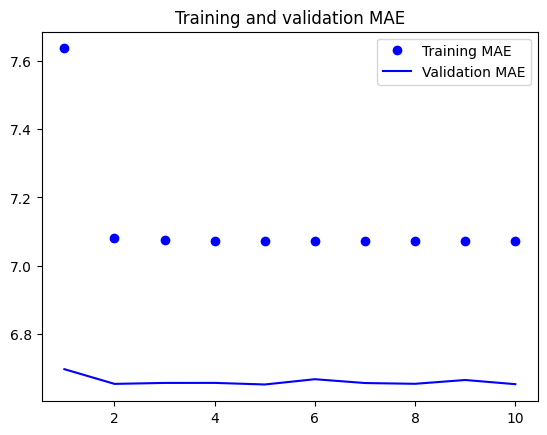

In [ ]:
from tensorflow.keras import layers

from tensorflow import keras

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

raw_data = raw_data.astype(np.float32)

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - loss: 30.1521 - mae: 4.2429 - val_loss: 16.5381 - val_mae: 3.1859
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 94ms/step - loss: 16.6617 - mae: 3.2332 - val_loss: 15.4364 - val_mae: 3.1136
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - loss: 14.3215 - mae: 2.9882 - val_loss: 15.5923 - val_mae: 3.1220
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 79s 96ms/step - loss: 13.1608 - mae: 2.8655 - val_loss: 13.9906 - val_mae: 2.9397
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 93ms/step - loss: 12.4396 - mae: 2.7850 - val_loss: 14.4600 - val_mae: 2.9836
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 79s 96ms/step - loss: 11.7673 - mae: 2.7073 - val_loss: 14.8498 - val_mae: 3.0405
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 78s 94ms/step - loss: 11.3137 - mae: 2.6512 - val_loss: 15.3813 - val_mae: 3.0960
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - loss: 10.9064 - mae: 2.6046 - val_loss: 14.5613 - val_mae: 2.9940
Epoch 9/10
819/819 ━━━━━

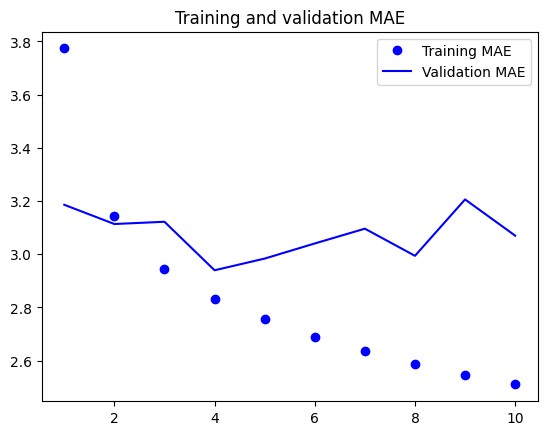

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - loss: 74.1139 - mae: 6.5809 - val_loss: 12.4730 - val_mae: 2.6921
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 132ms/step - loss: 11.9311 - mae: 2.6727 - val_loss: 9.6142 - val_mae: 2.4248
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 126ms/step - loss: 10.1129 - mae: 2.4862 - val_loss: 9.4436 - val_mae: 2.4031
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 134ms/step - loss: 9.6914 - mae: 2.4294 - val_loss: 9.3675 - val_mae: 2.3933
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 109s 133ms/step - loss: 9.3419 - mae: 2.3794 - val_loss: 9.6659 - val_mae: 2.4226
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 107s 130ms/step - loss: 9.1229 - mae: 2.3465 - val_loss: 9.6168 - val_mae: 2.4116
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - loss: 8.9293 - mae: 2.3162 - val_loss: 9.9198 - val_mae: 2.4435
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 127ms/step - loss: 8.7419 - mae: 2.2905 - val_loss: 9.6980 - val_mae: 2.4177
Epoch 9/10
819/819 ━

In [ ]:
from typing_extensions import final
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

# Numpy implementation of simple RNN

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 202s 243ms/step - loss: 49.9879 - mae: 5.2647 - val_loss: 9.5384 - val_mae: 2.3984
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 180s 219ms/step - loss: 15.3797 - mae: 3.0466 - val_loss: 9.0913 - val_mae: 2.3419
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 207s 225ms/step - loss: 14.6021 - mae: 2.9609 - val_loss: 8.9301 - val_mae: 2.3241
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 186s 226ms/step - loss: 14.0396 - mae: 2.9084 - val_loss: 8.8591 - val_mae: 2.3107
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 207s 232ms/step - loss: 13.6050 - mae: 2.8614 - val_loss: 8.9364 - val_mae: 2.3190
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 171s 208ms/step - loss: 13.2917 - mae: 2.8304 - val_loss: 8.7578 - val_mae: 2.2927
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 173s 211ms/step - loss: 12.9265 - mae: 2.7916 - val_loss: 8.7725 - val_mae: 2.2981
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 210s 220ms/step - loss: 12.6128 - mae: 2.7586 - val_loss: 8.8129 - val_mae: 2.3060
Epoch 9/50
819/8

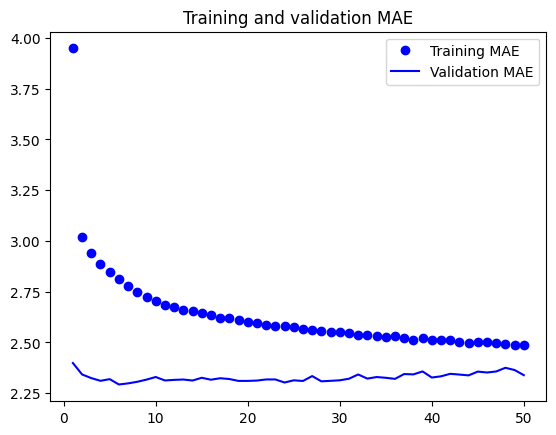

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

# Bidirectional implementation